In [1]:
# fix python path if working locally
from helpers import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

import requests
import io
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime as dt

from darts import TimeSeries
from darts.models import (
    BlockRNNModel,
)
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [7]:
# Importing Training Set
def loadDataset(url):
    s=requests.get(url).content
    dataset = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
    dataset.livingroom_window_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.livingroom_door_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.balcony_door_open = dataset.livingroom_door_open.replace({True: 1, False: 0})
    dataset.kitchen_window_open = dataset.kitchen_window_open.replace({True: 1, False: 0})
    dataset.timestamp = pd.Series([dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in list(dataset['timestamp'])]).round("10S")

    # Select features (columns) to be involved intro training and predictions
    cols = ["timestamp", "co2", "livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open", "rtemperature", "rhumidity", "temperature_outdoor", "humidity_outdoor"]
    return dataset[cols].drop_duplicates(subset=['timestamp'], keep='last')

In [8]:
dataset = loadDataset("https://iaq-data.brgr.rocks/full.csv")
print(dataset.tail)

<bound method NDFrame.tail of                  timestamp      co2  livingroom_window_open  \
0      2022-05-03 16:12:40   606.62                       0   
1      2022-05-03 16:12:50   605.24                       0   
2      2022-05-03 16:13:00   604.32                       0   
3      2022-05-03 16:13:10   604.82                       0   
4      2022-05-03 16:13:20   606.36                       0   
...                    ...      ...                     ...   
503955 2022-07-08 03:59:40  1015.04                       0   
503956 2022-07-08 03:59:50  1015.51                       0   
503957 2022-07-08 04:00:00  1016.00                       0   
503958 2022-07-08 04:00:10  1016.32                       0   
503959 2022-07-08 04:00:20  1015.67                       0   

        livingroom_door_open  balcony_door_open  kitchen_window_open  \
0                          0                  0                    0   
1                          0                  0                    0 

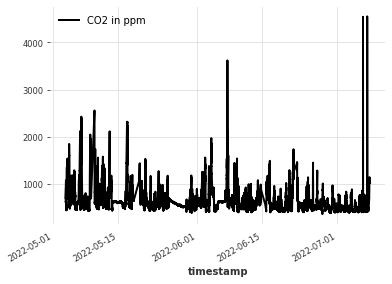

In [9]:
# series to predict, in this case CO2
series_co2 = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" ), fill='auto')

# covariates to help predict the CO2 series
covariates_livingroom_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_balcony_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_livingroom_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_kitchen_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'kitchen_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rtemperature', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rhumidity', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'temperature_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'humidity_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')


series_co2.plot(label="CO2 in ppm")
plt.legend()

In [10]:
scaler = Scaler()
series_co2_scaled = scaler.fit_transform(series_co2)
covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled, covariates_livingroom_window_open_scaled, covariates_kitchen_window_open_scaled, covariates_temperature_indoors_scaled, covariates_humidity_indoors_scaled, covariates_temperature_outdoors_scaled, covariates_humidity_outdoors_scaled = scaler.fit_transform([covariates_livingroom_door_open, covariates_balcony_door_open, covariates_livingroom_window_open, covariates_kitchen_window_open, covariates_temperature_indoors, covariates_humidity_indoors, covariates_temperature_outdoors, covariates_humidity_outdoors])

In [29]:
train_split = 30000

# training data
train_series_co2 = series_co2_scaled[:train_split]
train_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_balcony_door_open = covariates_balcony_door_open_scaled[:train_split]
train_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[:train_split]
train_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[:train_split]
train_covariates_temperature_indoors = covariates_temperature_indoors_scaled[:train_split]
train_covariates_humidity_indoors = covariates_humidity_indoors_scaled[:train_split]
train_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[:train_split]
train_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[:train_split]
train_covariants = train_covariates_livingroom_door_open.stack(train_covariates_balcony_door_open).stack(train_covariates_livingroom_window_open).stack(train_covariates_kitchen_window_open).stack(train_covariates_temperature_indoors).stack(train_covariates_humidity_indoors).stack(train_covariates_temperature_outdoors).stack(train_covariates_humidity_outdoors)

# test data
test_series_co2 = series_co2_scaled[-train_split:]
test_covariates_livingroom_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_balcony_door_open = covariates_balcony_door_open_scaled[-train_split:]
test_covariates_livingroom_window_open = covariates_livingroom_window_open_scaled[-train_split:]
test_covariates_kitchen_window_open = covariates_kitchen_window_open_scaled[-train_split:]
test_covariates_temperature_indoors = covariates_temperature_indoors_scaled[-train_split:]
test_covariates_humidity_indoors = covariates_humidity_indoors_scaled[-train_split:]
test_covariates_temperature_outdoors = covariates_temperature_outdoors_scaled[-train_split:]
test_covariates_humidity_outdoors = covariates_humidity_outdoors_scaled[-train_split:]
test_covariants = test_covariates_livingroom_door_open.stack(test_covariates_balcony_door_open).stack(test_covariates_livingroom_window_open).stack(test_covariates_kitchen_window_open).stack(test_covariates_temperature_indoors).stack(test_covariates_humidity_indoors).stack(test_covariates_temperature_outdoors).stack(test_covariates_humidity_outdoors)

In [30]:
model_co2 = BlockRNNModel(
    model="LSTM",
    input_chunk_length=90,
    output_chunk_length=90,
    n_epochs=1,
    random_state=0,
    dropout=0.1,
    model_name="LSTM",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    force_reset=True,
)

In [ ]:
model_co2.fit(series=train_series_co2, past_covariates=train_covariants, verbose=True)

In [34]:
model_co2.save_model('co2.pth.tar')

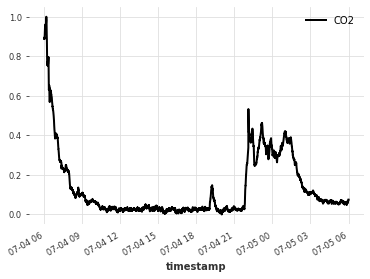

In [33]:
dataset = loadDataset("https://iaq-data.brgr.rocks/day.csv")

covariates_livingroom_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s")
covariates_balcony_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s")
series_co2 = TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" )
covariates_livingroom_door_open = fill_missing_values(covariates_livingroom_door_open, fill='auto')
covariates_balcony_door_open = fill_missing_values(covariates_balcony_door_open, fill='auto')
series_co2 = fill_missing_values(series_co2, fill='auto')

scaler = Scaler()
series_co2_scaled, covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled = scaler.fit_transform([series_co2, covariates_livingroom_door_open, covariates_balcony_door_open])

series_co2_scaled.plot(label="CO2")
plt.legend()


/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 14it [00:00, ?it/s]

<TimeSeries (DataArray) (timestamp: 8639, component: 1, sample: 1)>
array([[[826.22]],

       [[826.95]],

       [[827.72]],

       ...,

       [[429.21]],

       [[430.4 ]],

       [[431.23]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2022-07-04T06:00:30 ... 2022-07-05T...
  * component  (component) object 'co2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


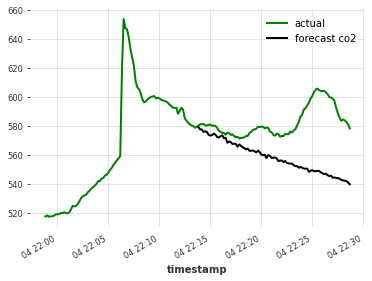

In [82]:
position = 5750
past = 90

train_series_co2 = series_co2_scaled[position:(position+past)]
train_covariates_livingroom_door_open = covariates_livingroom_door_open_scaled[position:(position+past)]
train_covariates_balcony_door_open = covariates_balcony_door_open_scaled[position:(position+past)]

actual_co2 = series_co2_scaled[position:(position+past*2)]

pred_list_scaled = model_co2.predict(n=past, series=[train_series_co2], past_covariates=[train_covariates_livingroom_door_open])

pred_list = scaler.inverse_transform(pred_list_scaled)
series_air = scaler.inverse_transform(series_co2_scaled)
series_actual = scaler.inverse_transform(actual_co2)

print(series_air)

series_actual.plot(label="actual", color="green")
for series, label in zip(pred_list, ["co2"]):
    series.plot(label=f"forecast {label}")
plt.legend()

In [33]:
from darts import metrics

#historical_fcast = model_co2.historical_forecasts(
# series=test_series_co2, past_covariates=test_covariants, start=90, forecast_horizon=90, verbose=False, retrain=False, overlap_end=False
#)

series_co2_real = scaler.inverse_transform(test_series_co2[180:])
historical_fcast_real = scaler.inverse_transform(historical_fcast)

series_co2_real.plot(label="actual")
historical_fcast_real.plot(label="predicted")

print(metrics.metrics.mae(series_co2_real, historical_fcast_real))

NameError: name 'historical_fcast' is not defined

In [3]:
model_co2 = BlockRNNModel.load_model('co2.pth.tar')

/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
